<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/Fine-Tuning_ML_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatische Erkennung von Musikinstrumenten
**Gruppe:** Grumpy

# Importe
Im Folgenden werden zunächst alle benötigten Libarys importiert die für dieses Notebook notwändig sind.

In [ ]:
! pip install keras-cv tensorflow --upgrade
! pip install keras_core

In [44]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from glob import glob
import cv2
import json
from keras.models import load_model
import keras_cv
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.utils import to_categorical
#from keras.src.layers.preprocessing.normalization import Normalization

# Der Datensatz

Dieser Abschnitt beinhaltet alle den Datensatz betreffenden Grundlagen. Hierzu gehören:
* der Hintergrund des Datensatzes,
* der Datenimport,
* das Definieren der Trainings-, Test- und Validierungsdatensätze,
* sowie die Datenexploration.

## Hintergrund

Der für dieses Projekt verwendete Datensatz [30 Musical Instruments -Image Classification](https://www.kaggle.com/datasets/gpiosenka/musical-instruments-image-classification?select=instruments.csv) stammt von Kaggle.com.

Die Bilder wurden von [Gerry ](https://www.kaggle.com/gpiosenka) bereitsgestellt und stammen aus einer strukturierten Internetrecherche.

Die Struktur der Daten kann auf Kaggle eingesehen werden und hat eine entscheidende Rolle in der Auswahl der Daten gespielt. Genauer stand für dieses Projekt die Verwendbarkeit im Fokus. Hier war eine Mindestanzahl an Bildern in geeigneter Struktur erforderlich.

Die Bilddaten sind nach Klassen in Ordner mit dem jeweiligen Namen strukturiert, was mit dem erforderlichen Input-Format der [image_dataset_from_directory](https://keras.io/api/data_loading/image/) funktion von Keras übereinstimmt.

Zusätzlich ist die Menge der Daten mit 5093 Bildern zwar ausbaufähig, für die Zwecke dieses Projektes jedoch ausreichend.  

Schließlich sprach noch die Vorverarbeitung für diesen Datensatz. Die Bilder wurden bereits auf Duplikate geprüft und in das einheitliche Format von 224 x 224 RGB gebracht, sodass diese Arbeiten in der vorverarbeitung eingesparrt werden können.


## Datenimport

Zunächst müssen die Daten aus Kaggle geladen werden. Hierfür wird die Kaggle API verwendet.

Für eine leichtere Kollaboration wird der private Kaggle-Token hard-codet in der Variable `json_token` gespeichert und in die Colab-Umgebung geladen.

Im Anschluss wird die Funktion `import_data()` definiert. Diese bildet alle notwendigen Schritte ab, um sich mittels des Tokens mit der Kaggle API zu verbinden und den Datensatz `musical-instruments-image-classification` zu laden.

*Referenz:*

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [3]:
# Hard-Coden des privaten Kaggle-Tokens

json_token = {"username":"mrommel","key":"ec48fc1622dfc43b58152e93be8b5a6a"}
with open('kaggle.json', 'w', encoding='utf-8') as file:
  json.dump(json_token, file, ensure_ascii=False, indent=4)

def import_data():
  '''
  Diese Funktion nutzt die Kaggle API mittels des json_token Objektes,
  um den musical-instruments-image-classification Datensatzes zu laden
  und zu entpacken.
  '''
  ! pip install -q kaggle
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download gpiosenka/musical-instruments-image-classification
  ! unzip musical-instruments-image-classification.zip

import_data()

Streaming output truncated to the last 5000 lines.
  inflating: test/harmonica/4.jpg    
  inflating: test/harmonica/5.jpg    
  inflating: test/harp/1.jpg         
  inflating: test/harp/2.jpg         
  inflating: test/harp/3.jpg         
  inflating: test/harp/4.jpg         
  inflating: test/harp/5.jpg         
  inflating: test/marakas/1.jpg      
  inflating: test/marakas/2.jpg      
  inflating: test/marakas/3.jpg      
  inflating: test/marakas/4.jpg      
  inflating: test/marakas/5.jpg      
  inflating: test/ocarina/1.jpg      
  inflating: test/ocarina/2.jpg      
  inflating: test/ocarina/3.jpg      
  inflating: test/ocarina/4.jpg      
  inflating: test/ocarina/5.jpg      
  inflating: test/piano/1.jpg        
  inflating: test/piano/2.jpg        
  inflating: test/piano/3.jpg        
  inflating: test/piano/4.jpg        
  inflating: test/piano/5.jpg        
  inflating: test/saxaphone/1.jpg    
  inflating: test/saxaphone/2.jpg    
  inflating: test/saxaphone/3.jpg    

## Trainings-, Test- und Validierungsdatensaetze definieren

Im folgenden werden die Trainings-, Test- und Validierungsdaten geladen und als Datensatz definiert.

Hierfür wird zunächst die funktion `load_data` definiert. Diese Funktion vermeidet Code redundanzen, welche durch das Laden der drei Datensätze andernfalls entstünden. Hier wurden alle gleichbleibenden Argumente bereits gesetzt. Die Funktion nimmt das Argument subset entgegen. `subset` ist der jeweilige Ordner (Train, Test oder Valid), aus welchem der Datensatz gebildet wird.

*Referenzen:*

https://keras.io/api/data_loading/image/

https://www.tensorflow.org/tutorials/images/classification

In [4]:
def load_data(subset):
  '''
  Diese Funktion lädt die Daten eines definierten Ordners und speichert diese
  in Bild-Label Kombinationen gemäß der Ordnerstruktur ab.

  *Args*
  subset: Nimmt einen String-Wert. Gibt den Ordner an, in dem sich die Daten befinden.
  '''
  return tf.keras.utils.image_dataset_from_directory(
    f"/content/{subset}",
    labels="inferred",
    #label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

In [5]:
# Laden der jeweiligen Datensätze

train_data = load_data("train")
test_data = load_data("test")
valid_data = load_data("valid")

Found 4793 files belonging to 30 classes.
Found 150 files belonging to 30 classes.
Found 150 files belonging to 30 classes.


## Datenexploration

TEXT ZUR DATENEXPLORATION

Zunächst werden die resultierenden Klassen geprüft. Diese sollten die Namen der 30 Instrumente beinhalten.

In [6]:
class_names = train_data.class_names
i = 0
for class_name in class_names:
  i += 1
  print(f"Instrument {i}: {class_name}")

Instrument 1: Didgeridoo
Instrument 2: Tambourine
Instrument 3: Xylophone
Instrument 4: acordian
Instrument 5: alphorn
Instrument 6: bagpipes
Instrument 7: banjo
Instrument 8: bongo drum
Instrument 9: casaba
Instrument 10: castanets
Instrument 11: clarinet
Instrument 12: clavichord
Instrument 13: concertina
Instrument 14: drums
Instrument 15: dulcimer
Instrument 16: flute
Instrument 17: guiro
Instrument 18: guitar
Instrument 19: harmonica
Instrument 20: harp
Instrument 21: marakas
Instrument 22: ocarina
Instrument 23: piano
Instrument 24: saxaphone
Instrument 25: sitar
Instrument 26: steel drum
Instrument 27: trombone
Instrument 28: trumpet
Instrument 29: tuba
Instrument 30: violin


Zusätzlich werden einige Bilder des Datensatzes betrachtet, um ein Gefühlt für die Bilder zu bekommen.
Hierfür werden 3 Bilder des Trainingsdatensatzes `train_data` mit ihrem Label dargestellt.

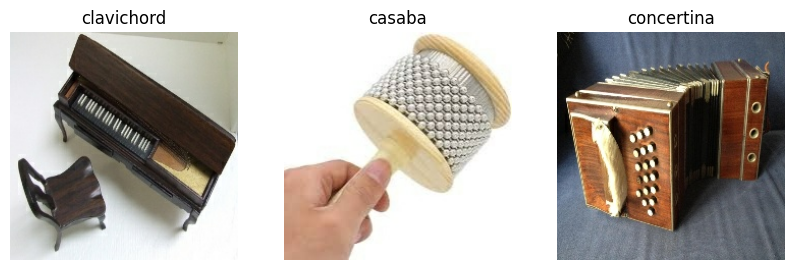

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Des weiteren wird das Format der Bilder geprüft.
Die funktion `.shape` gibt die beim Laden der Bilder definierte `batch size`, sowie Höhe, Breite und Anzahl der Farbkanäle der Bilder an.

Der Output zeigt, dass die Bilder 224x224 Pixel groß sind und in Farbe sind.

In [8]:
for images, labels in train_data.take(1):
  print(images.shape)

(32, 224, 224, 3)


# Modellerstellung
Im folgenden Abschnitt werden alle notewendigen Aspekte der Modellerstellung druchlaufen.

Hier zu gehören:
 * die Datenvorverarbeitung,
 * das Erstellen einer Modellarchitektur,
 * das Training und Testen des Modells,
 * sowie das Fine-Tuning.

Zum Abschluss wird die Performance des Modells mittels Cross-Validierung geprüft.

## Datenvorverarbeitung

Die Datenvorverarbeitung bietet die Möglichkeit, die Bilder zu verändern. Ein Mögliches Feld sind Augmentationen, welche verwendet werden, um die Menge der Bilder zu erhöhen oder zu diversifizieren. Beispiele hierfür sind das verändern des Kontrastes, sowie das spiegeln und drehen der Bilder.

Ein weiterer Anwendungsbereich ist die reduktion der Bilddaten. Dies kann sinnvoll sein, wenn der Detailgrad der Bilder hörer ist, als es für den Anwendungsfall von nöten ist. Da die vorliegenden Bilddaten mit 224x224 Pixeln in RGB verhältnismäßig groß sind, wird mit derartigen Methoden experimentiert.

Im Folgenden werden die Bilder verkleinert, von Farb- zu schwarz-weiß-Bildern verändert und normalisiert.

Referenzen:

https://www.tensorflow.org/tutorials/images/classification

https://keras.io/guides/preprocessing_layers/

https://chat.openai.com/share/4211047c-1904-4c0e-9ad1-9dc3c590233d


### Ändern der Farbkanäle

Im Folgenden werden die Farbkanäle von drei auf einen reduziert. Dies konvertiert die Bilder von Farb- zu schwarz-weiß Bildern.

Hierfür wird zunächst die Funktion `layers.Grayscale()` definiert. Hierdurch werden Coderedundanzen vermieden. Die Funktion nimmt das Argument `subset`, welches auf den jeweiligen Datensatz zeigt.

Im Anschluss wird die Funktion für Trainings-, Test- und Validierungsdatansatz aufgerufen und die Ergebnisse mit dem Prefix *greyscale_* gesichert.

Mittels der Funktion `.shape` kann im Anschluss erneut das Format der Bilder angezeigt werden. Man kann hier erkennen, dass sich die Farbkanäle von drei auf einen reduziert haben.

Schließlich werden die konvertierten Bilder visuell dargestellt.

In [9]:
def to_greyscale(subset):
  '''
  Diese Funktion kovertiert Farbbilder in schwarz-weiß Bilder.

  *Args:
  subset: Gibt den Datensatz an, der konvertiert werden soll.
  '''

  return subset.map(lambda x,y: (keras_cv.layers.Grayscale()(x), y))

In [10]:
# Konvertieren der Unterdatensätze in schwarz-weiß Bilder

greyscale_train_data = to_greyscale(train_data)
greyscale_test_data = to_greyscale(test_data)
greyscale_valid_data = to_greyscale(valid_data)

In [11]:
for images, labels in greyscale_train_data.take(1):
  print(images.shape)

(32, 224, 224, 1)


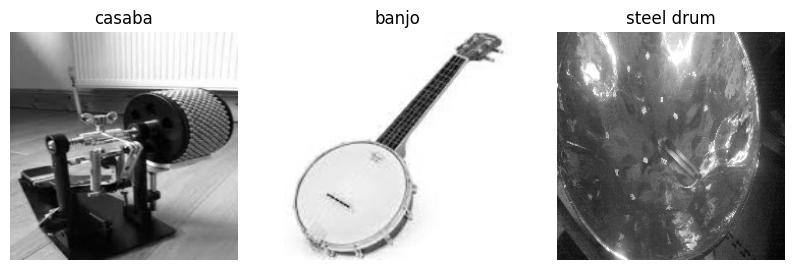

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in greyscale_train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    #cmap gibt die Farbkanäle an.
    #Da der Default RGB ist, muss dieser für schwarz-weiß Bilder definiert werden.
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")

    plt.title(class_names[labels[i]])
    plt.axis("off")

### Ändern der Bildgröße
In diesem Abschnitt wird die Bildgröße verändert.

Zunächst wird die Funktion `resize()` definiert. Hierdurch werden Coderedundanzen vermieden. Die Funktion nimmt das Argument `subset`, welches auf den jeweiligen Datensatz zeigt. Zusätzlich werden `height`und `width`übergeben. Hierüber werden die gewünschte Breite und Höhe des Outputbildes definiert.

Im Anschluss wird die Funktion für Trainings-, Test- und Validierungsdatansatz aufgerufen und die Ergebnisse mit dem Prefix *resize_* gesichert.

Mittels der Funktion `.shape` kann im Anschluss erneut das Format der Bilder angezeigt werden. Man kann hier erkennen, dass sich die Anzahl der Pixel in Höhe und Breite reduziert hat.

Schließlich werden die konvertierten Bilder visuell dargestellt. Die verschlechterung der Qualität ist deutlich sichtbar.

In [13]:
def resize(subset, height, width):
  '''
  Diese Funktion verändert die Größe von Bildern.

  *Args:
  subset: Gibt den Datensatz an, der konvertiert werden soll.
  height: Gibt die gewünschte Höhe an.
  width: Gibt die gewünschte Breite an.
  '''
  return subset.map(lambda x,y: (tf.keras.layers.Resizing(height, width)(x), y))

In [14]:
# Verkleinerung der Bilder der Unterdatensätze

resized_train_data = resize(train_data, 100,100)
resized_test_data = resize(test_data, 100,100)
resized_valid_data = resize(valid_data, 100,100)

In [15]:
for images, labels in resized_train_data.take(1):
  print(images.shape)

(32, 100, 100, 3)


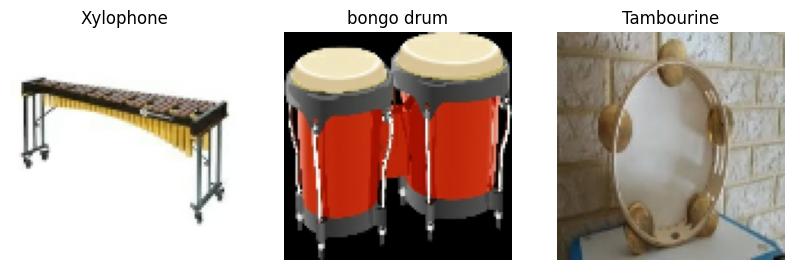

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in resized_train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title(class_names[labels[i]])
    plt.axis("off")

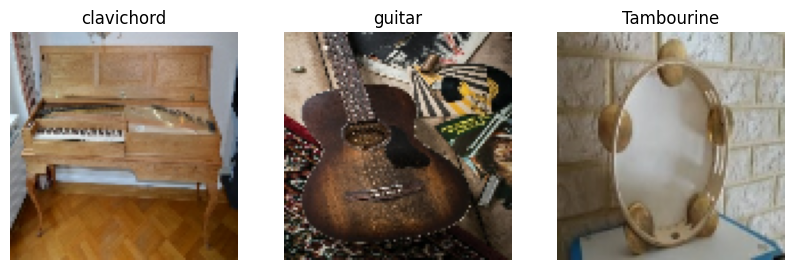

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in resized_train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalisieren der Pixelwerte

Die Pixelwerte der jeweiligen Bilder liegen zwischen 0 und 255.

Um Werte zwischen 0 und 1 zu erlangen, werden die Pixelwerte daher durch 255 geteilt.

In [18]:
# Minimum und Maximum der Pixel eines Beispielbildes abfragen

image_batch, labels_batch = next(iter(train_data))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 245.0


In [19]:
def normalize(subset):
  return subset.map(lambda x,y: (tf.keras.layers.Rescaling(1/255)(x), y))

In [50]:
# Normalisieren der Unterdatensätze

normal_train_data = normalize(resized_train_data)
normal_test_data = normalize(resized_test_data)
normal_valid_data = normalize(resized_valid_data)

In [21]:
# Minimum und Maximum der Pixel nach dem Normalisieren abfragen

image_batch, labels_batch = next(iter(normal_test_data))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


### One-Hot Encoding

Da der Datensatz Kategorische Label hat, welche für CNNs ungeeignet sind, müssen diese Dummy Codiert werden.

Hierfür wird zunächst die Funktion `one_hot ` definiert. Diese nimmt das Argument `subset `, was auf den Datensatz zeigt, der Dummy codiert werden soll.

Im Anschluss wird die Funktion auf die drei Unterdatensätze angewandt.

In [22]:
# Ausganslage analysieren

for image, label in train_data.take(1):
    print("Label:", label.numpy())

Label: [27  2  4 17 14  8 21 11  9 29 10 17 25 24  8 12 19 14  4 17  1  0 19 15
  7  8  3 12 17  3 28  9]


In [23]:
def one_hot(subset):
  '''
  Diese Funktion Dummy-codiert die Labels eines Datensatzes

  *Args:
  subset: Gibt den Datensatz an der Dummy codiert werden soll.
  '''
  return subset.map(lambda x,y: (x, tf.one_hot(y,30)))

In [51]:
# Dummy codieren der Unterdatensätze

one_hot_train_data = one_hot(normal_train_data)
one_hot_test_data = one_hot(normal_test_data)
one_hot_valid_data = one_hot(normal_valid_data)

In [25]:
# Label überprüfen

for image, one_hot_label in one_hot_train_data.take(1):
    print("One-Hot Label:", one_hot_label.numpy())

One-Hot Label: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [26]:
# Initialize a variable to count the number of images
num_images = 0

# Iterate through the dataset and count the number of images
for x, y in one_hot_train_data:
    num_images += x.shape[0]

# Print the number of images in normal_train_data
print("Number of images in normal_train_data:", num_images)

Number of images in normal_train_data: 4793


## Augmentation

Mit 4793 Trainingsbildern für 30 Klassen ist der Datensatz recht klein, was zu overfitting führen kann. Ein Lösungsansatz ist hier die verwendung von Bild Augmentationen. Hier werden die vorhandenen Bilder verändert, sodass das Modell pro Epoche nicht immer das gleiche Bild, sondern eine veränderte Version des Bildes bekommt. Dies wiederum kann bei overfitting helfen, da das Modell so schlechter 'auswendig lernen' kann, sondern eher generalisieren muss.

Im folgenden Abschnitt werden daher verschiedenne Methoden der Augmentation auf den Datensatz angewandt.

*Referenzen:*

https://keras.io/guides/preprocessing_layers/

In [ ]:
#
def augment(subset):
  '''
  Funktion verändert die Bilder eines Datensatzes.
  *Args:
  subset: Gibt den Datensatz an dessen Bilder verändert werden soll.
    '''
  augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ]
  )
  augmented_data = augmentation(subset)
  return augmented_data


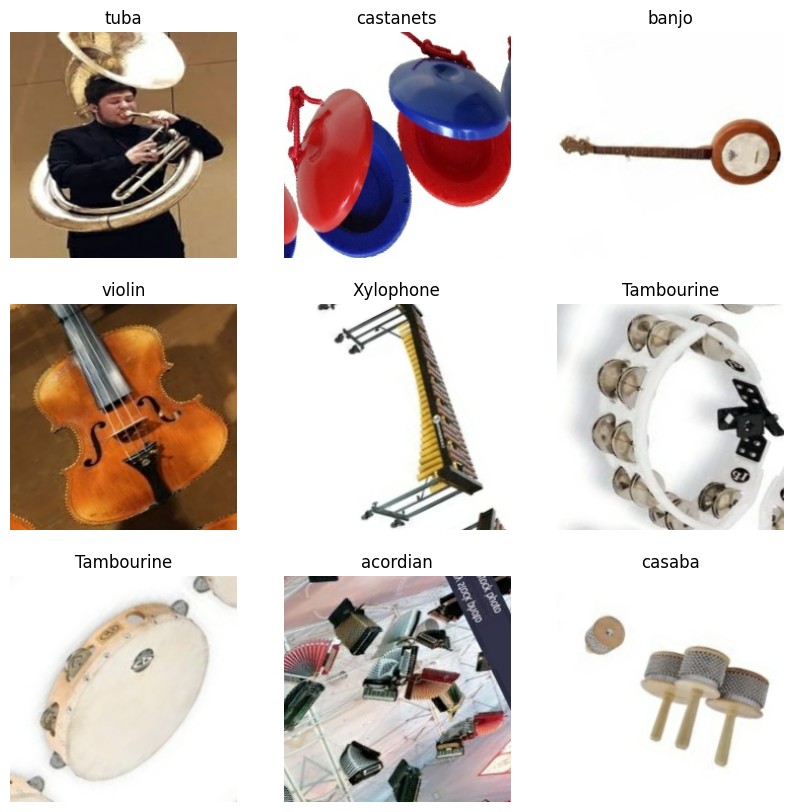

In [ ]:
# Augmentationen visualisieren

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    augmented = augment(images[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Modellarchitektur

Die Literaturrecherche zeigte verschiedenne CNN-Architekturen, welche gute bis sehr gute Ergebnisse in der Objekterkennung erlangen. Die kleinste davon ist AlexNet. Aus diesem Grund wird zunächst eine AlexNet Architektur erstellt, um dies als Referenz und Grundlage zu verwenden.

Im Anschluss kann das Modell über `model.summary() `untersucht werden.

*Referenzen:*

https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5

https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

https://keras.io/examples/vision/image_classification_from_scratch/

https://towardsdatascience.com/build-your-own-deep-learning-classification-model-in-keras-511f647980d6

https://keras.io/guides/sequential_model/



In [ ]:
'''
AlexNet Model 1
'''

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    input_shape= (224,224,3),
    filters=96,
    kernel_size=(11,11),
    strides=(4,4),
    activation="relu",
    #padding=0,
    ))
##kleineres Kernel würde besser zu diesem MaxPooling passen
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(5,5),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
## ggf eine der FC layer rausschmeißen
model.add(tf.keras.layers.Dense(
    units=4096,
    activation= "relu"
))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))
### mehr layer oben, stride runter (laufzeit), kernel size runter ganz oben? mehr filter? --> mehr Geichgewicht

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    input_shape= (100,100,3),
    filters=96,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    #padding=0,
    ))
##kleineres Kernel würde besser zu diesem MaxPooling passen
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
## ggf eine der FC layer rausschmeißen
#model.add(tf.keras.layers.Dense(
#    units=4096,
#    activation= "relu"
#))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))
### mehr layer oben, stride runter (laufzeit), kernel size runter ganz oben? mehr filter? --> mehr Geichgewicht

In [ ]:
'''
Mit Augmentation
'''


model = tf.keras.Sequential()
model.add(tf.keras.layers.RandomFlip("horizontal"))
model.add(tf.keras.layers.RandomRotation(0.2)),
model.add(tf.keras.layers.RandomZoom(0.1)),
#model.add(tf.keras.layers.RandomCrop(32,32)),
model.add(tf.keras.layers.Conv2D(
    input_shape= (100,100,3),
    filters=96,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    #padding=0,
    ))
##kleineres Kernel würde besser zu diesem MaxPooling passen
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
## ggf eine der FC layer rausschmeißen
#model.add(tf.keras.layers.Dense(
#    units=4096,
#    activation= "relu"
#))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))
### mehr layer oben, stride runter (laufzeit), kernel size runter ganz oben? mehr filter? --> mehr Geichgewicht



In [ ]:
'''
Mehr Layers
'''


model = tf.keras.Sequential()
model.add(tf.keras.layers.RandomFlip("horizontal"))
model.add(tf.keras.layers.RandomRotation(0.2)),
model.add(tf.keras.layers.RandomZoom(0.1)),
#model.add(tf.keras.layers.RandomCrop(32,32)),
model.add(tf.keras.layers.Conv2D(
    input_shape= (100,100,3),
    filters=96,
    kernel_size=(2,2),
    strides=(1,1),
    activation="relu",
    #padding=0,
    ))
model.add(tf.keras.layers.Conv2D(
    filters=160,
    kernel_size=(3,3),
    strides=(2,2),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=160,
    kernel_size=(2,2),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(3,3),
    strides=(2,2),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(2,2),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=384,
    kernel_size=(3,3),
    strides=(2,2),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(1,1),
    strides=(1,1),
    activation="relu",
    padding="same"
))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3,3),
    strides=(2,2)
))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4096,
    activation="relu"
))
## ggf eine der FC layer rausschmeißen
#model.add(tf.keras.layers.Dense(
#    units=4096,
#    activation= "relu"
#))
model.add(tf.keras.layers.Dense(
    units=30,
    activation="softmax"
))
### mehr layer oben, stride runter (laufzeit), kernel size runter ganz oben? mehr filter? --> mehr Geichgewicht



In [ ]:
# Übersicht der Layer und Parameter des Modells aufrufen

model.summary()

ValueError: ignored

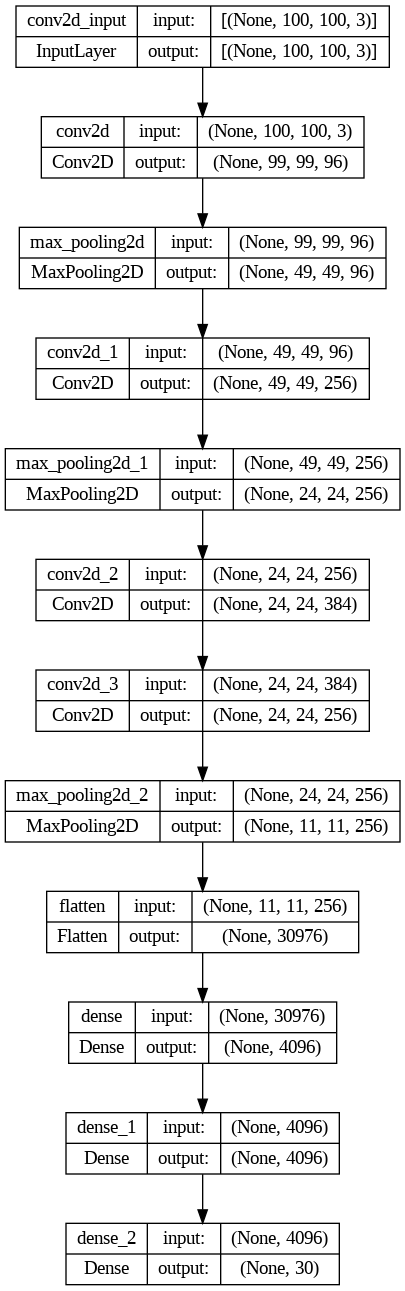

In [ ]:
# Hierarchisches Diagram des Modells darstellen

plot_model(model, to_file='convnet.png', show_shapes=True,
                 show_layer_names=True)
Image(filename='convnet.png')

# Code aus dem Buch Seite 736

## Modell Training und Test

In diesem Abschnitt wird das Modell mittels `.compile` zunächst erstellt.
Im Anschluss wird dieses mit den ausgewählten Daten trainiert und getestet.

In [ ]:
# Modell erstellen

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Modell trainieren und testen

model.fit(
    one_hot_train_data,
    epochs=5,
    validation_data=one_hot_test_data,
)

In [ ]:
# Modell trainieren und testen

history = model.fit(
    one_hot_train_data,
    epochs=20,
    batch_size=64,
    validation_data=one_hot_test_data,
)

Epoch 1/20
150/150 [==============================] - 50s 273ms/step - loss: 3.3842 - accuracy: 0.0511 - val_loss: 3.4039 - val_accuracy: 0.0333
Epoch 2/20
150/150 [==============================] - 39s 257ms/step - loss: 3.2561 - accuracy: 0.0851 - val_loss: 3.1083 - val_accuracy: 0.1000
Epoch 3/20
150/150 [==============================] - 39s 258ms/step - loss: 3.0903 - accuracy: 0.1291 - val_loss: 2.9422 - val_accuracy: 0.1400
Epoch 4/20
150/150 [==============================] - 38s 254ms/step - loss: 2.9821 - accuracy: 0.1607 - val_loss: 2.7396 - val_accuracy: 0.2067
Epoch 5/20
150/150 [==============================] - 38s 255ms/step - loss: 2.8991 - accuracy: 0.1790 - val_loss: 2.5956 - val_accuracy: 0.2667
Epoch 6/20
150/150 [==============================] - 38s 254ms/step - loss: 2.8142 - accuracy: 0.2082 - val_loss: 2.5309 - val_accuracy: 0.2467
Epoch 7/20
150/150 [==============================] - 38s 255ms/step - loss: 2.7239 - accuracy: 0.2316 - val_loss: 2.4997 - val_ac

Nachdem das Modell trainiert und getestet wurde, wird der Verlauf der Accuracy über die Epochen hinweg visualisiert.

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy


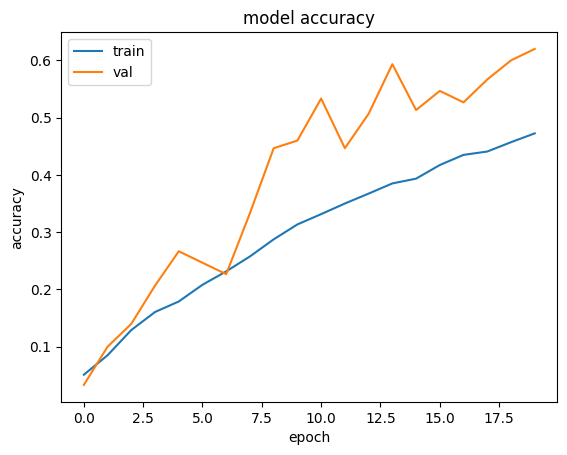

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ResNet

*Referenzen:*

https://arxiv.org/pdf/1512.03385.pdf



# ResNet 50 Architektur

ResNet steht für Residual Network. ResNet ist eine spezielle Form der neuronalen Netze welche 2015 im Paper „Deep Residual Learning for Image Recognition“ von Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun vorgestellt wurde. Ziel ihrer Arbeit war es das Training von tieferen neuronalen Netzen zu vereinfachen. Die Besonderheit des Resnet Architektur besteht in den entwickelten „residual Blocks“, welche den Input des vorherigen Layers mit dem Output des aktuellen Layers verbindet.
Mathematisch kann man sich dies wie folgt vorstellen:
Sei x der Output eines vorherigen Layers dann stellt F(x) eine Funktion dar, welche im aktuellen Layer x verwendet, um zu trainieren. Bevor die Ergebnisse F(x) in den nächsten Layer gegeben werden wird F(x) mit +x erweitert, wobei x immer noch die Ergebnisse eines vorherigen Layers definiert.
(https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)


Die im folgenden genutzte Architektur ist ResNet 50. Die Zahl definiert hierbei die Anzahl der genutzten Layer. Auch wenn ResNet 152 im Paper ursprünglich als die beste Architektur herausgestellt wurde, wir häufig auf Resnet 50 zurückgegriffen. ResNet 50 ist nicht signifikant schlechter, aber deutlich performanter als ResNet 152 im Bezug auf Trainingszeiten (https://arxiv.org/pdf/2002.08991.pdf#:~:text=The%20best%20classifications%20of%20pulmonary,ResNet%2D50%20(0.590).)

Die ResNet 50 Architektur bildet sich klassischerweise wie folgt:
1 Konvolution Layer mit einer Kernelgröße von 7*7 aus 64 verschiedenen Kerneln mit einer stride von 2.
9 Max-Pooling Layer welche aus einem sich dreimal wiederholenden Block besteht aus: 64 Kernel mit einer Größe von 1*1, 64 Kernel mit einer Größe von 3*3 sowie 256 Kernel wieder mit einer Größe von 1*1.
12 Layer die sich aus einem sich viermal wiederholenden Block aus folgenden Layern bildet: einem 128 Kernel großen Layer mit einer Größe von 1*1, gefolgt von einem weiteren 128 Kernel großen Layer diesmal mit einer 3*3 Größe und einem 512 Kernel großen Layer welcher wieder die Größe von 1*1 nutzt.
18 Layer die sich aus folgenden drei Layern, welche sechsmal wiederholt werden, zusammensetzt: eine 1*1 Größe bei 256 Kerneln, 256 Kernel bei einer Größe von 3*3 sowie 1024 Kernel bei einer Größe von 1*1.
9 weitere Layer folgen in einem dreier Block von 512 Kernel bei einer 1*1 Größe, 512 Kernel bei einer Größe von 3*3 sowie 2048 Kernel bei einer Größe von 1*1. Auch dieser Block wiederholt sich dreimal.
1 Layer welcher zum schluss einen average pool welcher mit einer fully connected Layer beendet wird. Diese enthält 1000 nodes (Knoten) und endet mit der Aktivierung der „Softmax“ funktion.

(https://iq.opengenus.org/resnet50-architecture/)



## ResNet Performance Test

Referenzen:

https://keras.io/api/applications/resnet/#resnet50-function

https://keras.io/api/applications/#usage-examples-for-image-classification-models

https://keras.io/guides/transfer_learning/

In [53]:
# ResNet50 Modell mit den orgiginalen Gewichten laden
# Die Fully-Connected Layers werden nicht mit geladen.

ResNet_model = ResNet50(weights='imagenet', input_shape = (100,100,3), include_top = False)

#ResNet_model = ResNet50(weights='imagenet', input_tensor=Input(shape=(100, 100, 3)), include_top = False)


In [54]:
# Modell Einfrieren

ResNet_model.trainable = False

In [55]:
combined_model = tf.keras.models.Sequential()

combined_model.add(ResNet_model)
combined_model.add(tf.keras.layers.Flatten())
combined_model.add(tf.keras.layers.Dense(30, activation='softmax'))

In [ ]:
combined_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 30)                3010590   
                                                                 
Total params: 26598302 (101.46 MB)
Trainable params: 26545182 (101.26 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [56]:
combined_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [58]:
# Modell trainieren und testen

history = combined_model.fit(
    one_hot_train_data,
    epochs=30,
    validation_data=one_hot_test_data,
)

Epoch 1/30
150/150 [==============================] - 6s 35ms/step - loss: 1.9827 - accuracy: 0.5007 - val_loss: 2.0417 - val_accuracy: 0.4533
Epoch 2/30
150/150 [==============================] - 6s 40ms/step - loss: 1.9812 - accuracy: 0.5087 - val_loss: 1.7153 - val_accuracy: 0.5733
Epoch 3/30
150/150 [==============================] - 5s 34ms/step - loss: 1.9530 - accuracy: 0.5155 - val_loss: 2.8996 - val_accuracy: 0.4333
Epoch 4/30
150/150 [==============================] - 7s 44ms/step - loss: 1.9518 - accuracy: 0.5220 - val_loss: 2.0450 - val_accuracy: 0.5133
Epoch 5/30
150/150 [==============================] - 5s 34ms/step - loss: 1.9275 - accuracy: 0.5245 - val_loss: 1.6773 - val_accuracy: 0.5800
Epoch 6/30
150/150 [==============================] - 6s 41ms/step - loss: 1.7572 - accuracy: 0.5483 - val_loss: 1.5569 - val_accuracy: 0.5867
Epoch 7/30
150/150 [==============================] - 5s 35ms/step - loss: 1.6343 - accuracy: 0.5706 - val_loss: 1.5844 - val_accuracy: 0.5667

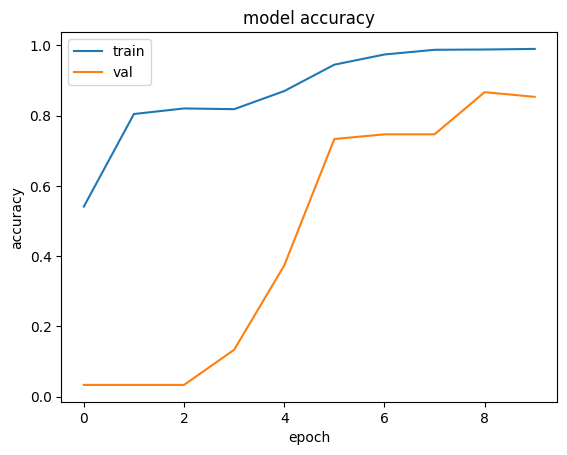

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## ResNet Fine-Tuning

https://keras.io/guides/transfer_learning/

In [60]:
# Unfreeze the base model
ResNet_model.trainable = True

combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train end-to-end. Be careful to stop before you overfit!
combined_model.fit(one_hot_train_data, epochs=30, validation_data=one_hot_test_data)

Epoch 1/30
150/150 [==============================] - 56s 125ms/step - loss: 8.4693 - accuracy: 0.3440 - val_loss: 105.6024 - val_accuracy: 0.0533
Epoch 2/30
150/150 [==============================] - 17s 115ms/step - loss: 3.6159 - accuracy: 0.5362 - val_loss: 38.3712 - val_accuracy: 0.0467
Epoch 3/30
150/150 [==============================] - 17s 110ms/step - loss: 2.0140 - accuracy: 0.6697 - val_loss: 15.2245 - val_accuracy: 0.0733
Epoch 4/30
150/150 [==============================] - 16s 106ms/step - loss: 1.2234 - accuracy: 0.7688 - val_loss: 8.6966 - val_accuracy: 0.2400
Epoch 5/30
150/150 [==============================] - 17s 110ms/step - loss: 0.7254 - accuracy: 0.8291 - val_loss: 3.9956 - val_accuracy: 0.5067
Epoch 6/30
150/150 [==============================] - 17s 110ms/step - loss: 0.4538 - accuracy: 0.8865 - val_loss: 2.0317 - val_accuracy: 0.7267
Epoch 7/30
150/150 [==============================] - 16s 107ms/step - loss: 0.3047 - accuracy: 0.9168 - val_loss: 1.6512 - va